In [45]:
from collections import namedtuple
import QuantLib as ql
import pandas as pd
import numpy as np
from tabulate import tabulate

# Short rate IR models (and Bermudan swaptions)
This notebook shows examples of working with short rate IR models within the `QuantLib` library.

In particular it is shown how to calibrate the following short-rate models:
- HW1F model, 
- Vasicek model, 
- CIR model, 
- general GSR 1F model, 
- G2++ model.

We also show a very simple example of pricing a bermudan swaption.

# Define basic inputs

In [46]:
today = ql.Date(20, 10, 2022)
ql.Settings.instance().evaluationDate = today

calibration_data = namedtuple('calibration_data', ['expiry', 'tenor', 'volatility'])

data = [calibration_data('1Y', '5Y', 0.1148),
        calibration_data('2Y', '4Y', 0.1108),
        calibration_data('3Y', '3Y', 0.1070),
        calibration_data('4Y', '2Y', 0.1021),
        calibration_data('5Y', '1Y', 0.1000)]

display(pd.DataFrame(data).style.set_caption('Swaption calibration set').hide(axis = 0))

# define 3 curves:
# curve_disc and curve_fcst are discounting and forecasting curves, respectively. These are used for the analytical formula when determining Black/Bachelier prices
# curve model this is curve used by the IR model. This curve can be equal to the discounting/fcsting curve but generally it can be different
curve_disc  = ql.YieldTermStructureHandle(ql.FlatForward(today, 0.06, ql.SimpleDayCounter()))
curve_fcst  = ql.YieldTermStructureHandle(ql.FlatForward(today, 0.05, ql.SimpleDayCounter()))
curve_model = ql.YieldTermStructureHandle(ql.FlatForward(today, 0.05, ql.SimpleDayCounter()))

index = ql.Euribor6M(curve_fcst) # index of the floating leg; it plays no role when swaption is priced via IR model

expiry,tenor,volatility
1Y,5Y,0.114800
2Y,4Y,0.110800
3Y,3Y,0.107000
4Y,2Y,0.102100
5Y,1Y,0.100000


# Simple example of pricing a 5Yx5Y vanilla swaption
This section illustrates a simple swaption pricing using a pre-calibrated HW model.

In [47]:
swap = ql.MakeVanillaSwap(ql.Period('5y'), index, 0.08, ql.Period('5y'), discountingTermStructure = curve_disc)

exerciseDate = ql.TARGET().advance(today, ql.Period('5y'))
swaption = ql.Swaption(swap, ql.EuropeanExercise(exerciseDate))

hwmodel = ql.HullWhite(curve_model, a = 0.01, sigma = 0.025)
swaption.setPricingEngine(ql.JamshidianSwaptionEngine(hwmodel))
swaption.NPV()

0.037139982719326815

# Pricing a bermudan swaption

Bermudan swaption gives us the right to to enter into a $[{T_\alpha },{T_\beta }]$ swap at specified times $\mathcal{T} = \{\tau\}$ such that $T_\alpha \le \tau < T_\beta$.
We use the swap as defined above and adjust the payoff to Bermudan.

In [48]:
bermudan_dates = [d for d in swap.fixedSchedule()][:-1]
exercise = ql.BermudanExercise(bermudan_dates)
swaption = ql.Swaption(swap, exercise)
swaption.setPricingEngine(ql.FdHullWhiteSwaptionEngine(hwmodel))
#swaption.setPricingEngine(ql.TreeSwaptionEngine(hwmodel, 100))
swaption.NPV()

0.04656806507181071

# Calibration

Calibration follows the following schema:
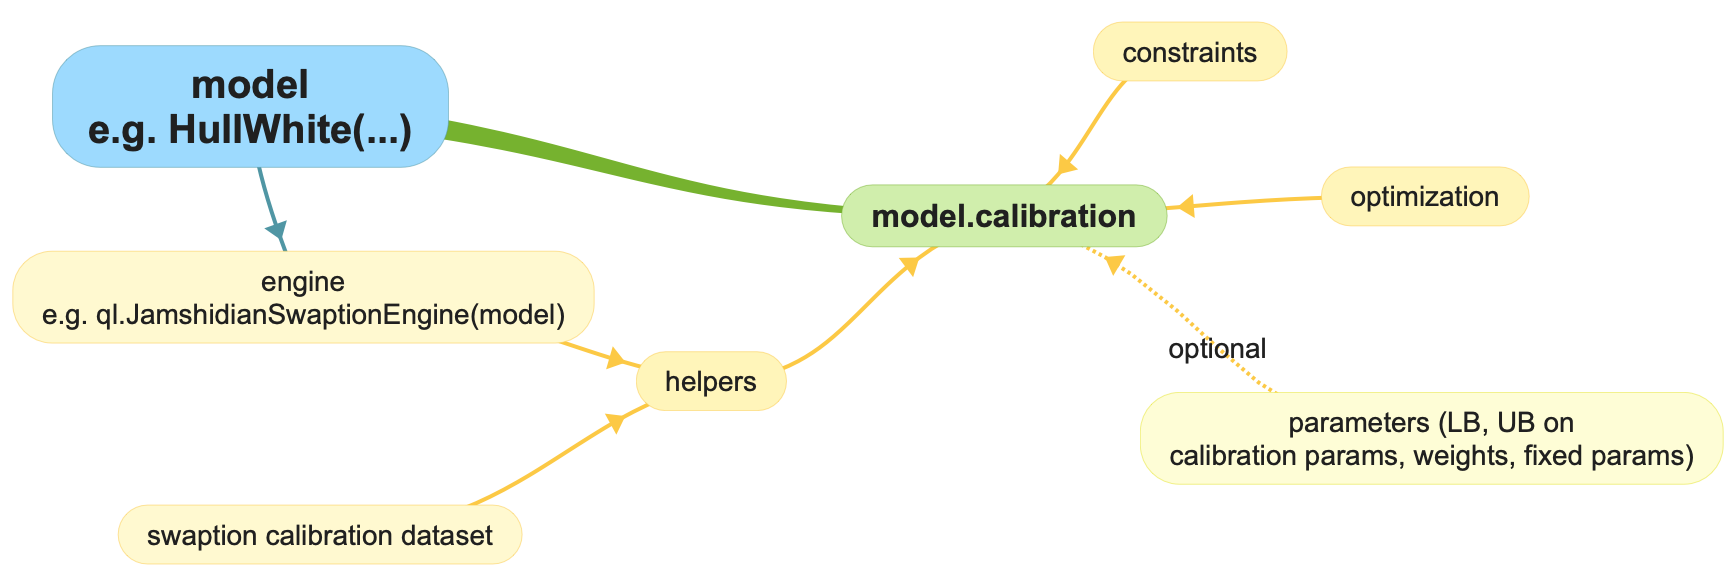

That is:
- we first define a vanialla _model_ e.g. `ql.HullWhite(...)`, 
- then we define _helpers_ which are later required by calibration. These consume i) the calibration dataset ii) _engine_ (such as `ql.JamshidianSwaptionEngine(model)`) which determines the method of pricing, combined with a _model_. E.g. `ql.JamshidianSwaptionEngine` represents analytical formula, and when combined with `model=ql.HullWhite` we will be calibrating the model using analytical swaption formula based on HW model.
- _model_ can be calibrated by calling `calibrate` function which consumes (in the order of arguments):
    - _helpers_ (containing the associated model),
    - optimization method. Either `ql.Simplex(0.05)` or `ql.LevenbergMarquardt(1.0e-8,1.0e-8,1.0e-8)`,
    - end criteria. E.g. `ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)`,
    - boundary constraint on all parameters. E.g. `ql.NoConstraint()` or `ql.BoundaryConstraint(0.0, 0.5)` (all parameters limited to [0,0.5])
    - weights of swaption quotes e.g. `[0.2, 0.2, 0.2, 0.2, 0.2]`
    - which parameters to keep fixed. E.g. `[False, True]` will make the first param flexible and will fix the second one.
    

Once the calibration is done, pricing is easy. We take a swaption object and set pricing engine with the embedded calibrated model and we can price directly.

In [49]:
def build_calibration_helpers(calibration_data, engine):
    '''
        Function builds swaption helper objects needed for calibration.
        We can then use use these prepared helpers in IR mode calibration
        
        engine (containing the to-be-calibrated model) is associated with each swaption helper.
        Example of engine: Engine is e.g. engine = ql.JamshidianSwaptionEngine(model) where model is the model we want to calibrate, e.g. ql.HullWhite(...)
    '''
    index = ql.Euribor6M(curve_fcst) # index of the floating leg of the swap, underlying each swaption 
    
    strike = ql.nullDouble() # null strike = ATM swaption defined by curve_disc and curve bound to index
    notional = 1.0
    
    model_swaption = ql.ShiftedLognormal
    shift = 0.02
    
    # type of error that will be used for the IR model fitting/calibration
    error_type = ql.BlackCalibrationHelper.ImpliedVolError
    
    # some secondary trade attribues of the swap(tion)
    fixed_leg_tenor = ql.Period('1Y')
    fixed_leg_daycounter = ql.Actual360()
    floating_leg_daycounter = ql.Actual360()
    
    
    helpers = []
    for d in data:
        helper = ql.SwaptionHelper(ql.Period(d.expiry), 
                                   ql.Period(d.tenor),
                                   ql.QuoteHandle(ql.SimpleQuote(d.volatility)),
                                   index,
                                   fixed_leg_tenor,
                                   fixed_leg_daycounter,
                                   floating_leg_daycounter,
                                   curve_disc,
                                   error_type, 
                                   strike, 
                                   notional, 
                                   model_swaption, 
                                   shift)
        helper.setPricingEngine(engine)
        helpers.append(helper)
    return helpers

In [50]:
def calibration_report(helpers):
    '''
        Function takes helpers (ideally after calibration, i.e. which already contain calbrated model)
        and shows overview of fitting (market price, model prices, IV market, IV model)
    '''
    calibresults = namedtuple('calibration_results', ['implied_vol_market', 
                                                      'implied_vol_model', 
                                                      'price_market', 
                                                      'price_model', 
                                                      'strike', 
                                                      'expiry', 
                                                      'swap_termination'])
    res = []
    for helper in helpers:
        res.append(calibresults(helper.impliedVolatility(helper.marketValue(), 1e-8, 10000, 0.0001, 2),
                                helper.impliedVolatility(helper.modelValue(),  1e-8, 10000, 0.0001, 2),
                                helper.marketValue(),
                                helper.modelValue(),
                                helper.swaptionStrike(),
                                helper.swaptionExpiryDate().to_date(),
                                helper.swaptionMaturityDate().to_date())
                  )
    res = pd.DataFrame(res).rename_axis('swaption')
    
    # computation of errros (to display only)
    IV_rel_diff = np.abs(res.eval('(implied_vol_model - implied_vol_market)/implied_vol_market').sum())
    IV_abs_diff = np.abs(res.eval('implied_vol_model - implied_vol_market').sum())
    price_rel_diff = np.abs(res.eval('(price_model - price_market)/price_market').sum())
    price_abs_diff = np.abs(res.eval('price_model - price_market').sum())
    
    print(f'IV relative diff {IV_rel_diff}')
    print(f'IV abs diff {IV_abs_diff}')
    print(f'Price relative diff {price_rel_diff}')
    print(f'Price abs diff {price_abs_diff}')
    
    return res

## Calibration of HW model
HW model is defined as 
\begin{equation*}
dr(t) = \left( {\theta (t) - ar(t)} \right)dt + \sigma dW(t).
\end{equation*}

In [51]:
model = ql.HullWhite(curve_model, 0.05, 0.01)  # define basic inputs. The params also serve as initial guess
engine = ql.JamshidianSwaptionEngine(model) # analytical engine

# alternative engines
# engine = ql.TreeSwaptionEngine(model, 100) # use binomial tree
# engine = ql.FdHullWhiteSwaptionEngine(model,300, 300,0, 1e-5,ql.FdmSchemeDesc.CrankNicolson()) FDM method, only first parameter is mandatory
helpers = build_calibration_helpers(calibration_data, engine)

# define optimization criteria (optimization method and end criteria)
optimization_method = ql.Simplex(0.05)
# optimization_method = ql.LevenbergMarquardt(1.0e-8,1.0e-8,1.0e-8) alternative method
end_criteria = ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)
model.calibrate(helpers, optimization_method, end_criteria, ql.BoundaryConstraint(0.0, 0.5), [0.2, 0.2, 0.2, 0.2, 0.2], [False, False])

# print calibration report
print(tabulate(calibration_report(helpers), headers = 'keys', tablefmt = 'orgtbl'), '\n')

params = pd.Series(np.array(model.params()), index = ['a', 'sigma']).to_dict()
print(f"Estimated HW parameters: a = {params['a']:.4f}, sigma = {params['sigma']:.4f}")

IV relative diff 0.011380071614103829
IV abs diff 0.0002468032532856185
Price relative diff 0.011001998937823124
Price abs diff 0.0007433113873434941
|   swaption |   implied_vol_market |   implied_vol_model |   price_market |   price_model |    strike | expiry     | swap_termination   |
|------------+----------------------+---------------------+----------------+---------------+-----------+------------+--------------------|
|          0 |               0.1148 |            0.106758 |     0.0129465  |    0.0120404  | 0.0506416 | 2023-10-20 | 2028-10-24         |
|          1 |               0.1108 |            0.106431 |     0.0137133  |    0.0131736  | 0.0506656 | 2024-10-21 | 2028-10-23         |
|          2 |               0.107  |            0.106636 |     0.0117896  |    0.0117496  | 0.0506554 | 2025-10-20 | 2028-10-23         |
|          3 |               0.1021 |            0.107046 |     0.00839918 |    0.00880455 | 0.0506327 | 2026-10-20 | 2028-10-23         |
|          4 |  

## Calibration of Vasicek model
Vasicek is defined as
\begin{equation*}
dr(t) = a\left( {b - r(t)} \right)dt + \sigma dW(t).
\end{equation*}

Inside `QuantLib` the Vasicek model reads: `ql.Vasicek(r0, a, b, sigma, lambda_parameter)`.   
Here, `r0` is the initial rate and is **very important** because it determines the term structure. Although in the case of Vasicek we _need_ to pass a true curve into the _engine_, such a term structure is actually ignored.

Note that Vasicek also consumes the $\lambda$ parameter, which is market price of risk.

In [52]:
model = ql.Vasicek(r0=0.03, a=0.1, b=0.05, sigma=0.01, lambda_parameter=0.0)  # define basic parameters and r(0). r(0) will be kept as fixed, very important.
engine = ql.JamshidianSwaptionEngine(model, curve_model) # analytical engine

# alternative engines
# engine = ql.TreeSwaptionEngine(model, 100, curve_fcst) # use binomial tree

helpers = build_calibration_helpers(calibration_data, engine)

# define optimization criteria (optimization method and end criteria)
optimization_method = ql.Simplex(0.05)
# optimization_method = ql.LevenbergMarquardt(1.0e-8,1.0e-8,1.0e-8) alternative method
end_criteria = ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)
model.calibrate(helpers, optimization_method, end_criteria, ql.BoundaryConstraint(0.0, 1), [0.2, 0.2, 0.2, 0.2, 0.2], [False, False, False, True])

# print calibration report
print(tabulate(calibration_report(helpers), headers = 'keys', tablefmt = 'orgtbl'), '\n')

params = pd.Series(np.array(model.params()), index = ['a', 'b', 'sigma', 'lambda']).to_dict()
print(f"Estimated Vasicek parameters: a = {params['a']:.4f}, a = {params['b']:.4f}, sigma = {params['sigma']:.4f}, lambda = {params['lambda']:.4f}")

IV relative diff 4.607119606015505e-05
IV abs diff 5.3706793058661e-07
Price relative diff 4.610407348401872e-05
Price abs diff 3.627472549309549e-07
|   swaption |   implied_vol_market |   implied_vol_model |   price_market |   price_model |    strike | expiry     | swap_termination   |
|------------+----------------------+---------------------+----------------+---------------+-----------+------------+--------------------|
|          0 |               0.1148 |           0.114721  |     0.0129465  |    0.0129376  | 0.0506416 | 2023-10-20 | 2028-10-24         |
|          1 |               0.1108 |           0.111222  |     0.0137133  |    0.0137654  | 0.0506656 | 2024-10-21 | 2028-10-23         |
|          2 |               0.107  |           0.106303  |     0.0117896  |    0.011713   | 0.0506554 | 2025-10-20 | 2028-10-23         |
|          3 |               0.1021 |           0.10256   |     0.00839918 |    0.00843689 | 0.0506327 | 2026-10-20 | 2028-10-23         |
|          4 |  

## Calibration of Cox-Ingersoll-Ross (CIR)

The dynamics in CIR is defined as 
\begin{equation*}
dr(t) = k\left( {\theta  - r(t)} \right)dt + \sigma \sqrt {r(t)} dW(t).
\end{equation*}

The model is conceptually similar to Vasicek, however in `QuantLib` there are some differences:
- CIR doesn't use `ql.JamshidianSwaptionEngine` engine, only `ql.TreeSwaptionEngine` is possible,
- $r_0$ actually **gets** calibrated in CIR (while it doesn't in the Vasicek case). In the output vector of 'parameters' $r_0$ is the last parameter,
- there is no market price of risk parameter $\lambda$ for CIR.

In [53]:
model = ql.CoxIngersollRoss(theta=0.05, k=0.1, sigma=0.01, r0=0.03)  # define parameters. Note that compared to Vasicek r0 actually gets calibrated (!)


# CIR supports only tree model
engine = ql.TreeSwaptionEngine(model, 100, curve_model) # use binomial tree

helpers = build_calibration_helpers(calibration_data, engine)

# define optimization criteria (optimization method and end criteria)
optimization_method = ql.Simplex(0.05)
# optimization_method = ql.LevenbergMarquardt(1.0e-8,1.0e-8,1.0e-8) alternative method
end_criteria = ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)
model.calibrate(helpers, optimization_method, end_criteria, ql.BoundaryConstraint(0.0, 1), [0.2, 0.2, 0.2, 0.2, 0.2], [False, False, False, False])

# print calibration report
print(tabulate(calibration_report(helpers), headers = 'keys', tablefmt = 'orgtbl'), '\n')

params = pd.Series(np.array(model.params()), index = ['a', 'b', 'sigma', 'r0']).to_dict()
print(f"Estimated CIR parameters: a = {params['a']:.4f}, b = {params['b']:.4f}, sigma = {params['sigma']:.4f}, r0 = {params['r0']:.4f}")

IV relative diff 2.832582221095432e-05
IV abs diff 2.374940404323289e-06
Price relative diff 2.824761065647603e-05
Price abs diff 2.99254687318503e-06
|   swaption |   implied_vol_market |   implied_vol_model |   price_market |   price_model |    strike | expiry     | swap_termination   |
|------------+----------------------+---------------------+----------------+---------------+-----------+------------+--------------------|
|          0 |               0.1148 |           0.114811  |     0.0129465  |    0.0129478  | 0.0506416 | 2023-10-20 | 2028-10-24         |
|          1 |               0.1108 |           0.110938  |     0.0137133  |    0.0137303  | 0.0506656 | 2024-10-21 | 2028-10-23         |
|          2 |               0.107  |           0.106589  |     0.0117896  |    0.0117445  | 0.0506554 | 2025-10-20 | 2028-10-23         |
|          3 |               0.1021 |           0.102427  |     0.00839918 |    0.00842602 | 0.0506327 | 2026-10-20 | 2028-10-23         |
|          4 | 

## Calibration of 1F Gaussian Short Rate (GSR) model
Generic short rate model with dynamics defined as 
\begin{equation*}
dr(t) = \varkappa (t)\left( {\theta (t) - r(t)} \right)dt + \sigma (t)dW(t).
\end{equation*}
Clearly, the mean reversion speed $\varkappa$ and the volatility $\sigma$ can be time-dependent. This is indeed the key advatange of GSR. In `QuantLib` $\sigma$ is piecewise-constant.

We note that the time-dependent volatility is function requires $n+1$ volatility quotes for $n$ time horizons. The way the piecewise-constant volatilities are picked is as follows.

\begin{equation*}
\sigma (t) = 
\begin{cases}
{\sigma _1}, & \text{ if } 0 \le t < {t_1}\\
 \vdots \\
{\sigma _n}, & \text{ if } {t_{n - 1}} \le t < {t_n} \\
\sigma _{n + 1}, & \text{ if } t \ge {t_n}
\end{cases}.
\end{equation*}

Additional comment is on the pricing engines. There are essentially two:
- `ql.Gaussian1dJamshidianSwaptionEngine` is the 'analytical' engine and uses for the entire pricing the curve of the model (not the curve of the floating leg, or discount curve). This engine can't be used to price bermudas,
- `ql.Gaussian1dSwaptionEngine` is the 'numerical' pricing engine which also respects the actual curve of the floating leg (but not the discounting curve). This engine can be used to price bermudas.

GSR model reference:
- https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2246013

In [54]:
volStepDates = [ql.Date(20, 10, 2023), ql.Date(20, 10, 2024), ql.Date(20, 10, 2025), ql.Date(20, 10, 2026)]
volatilities = (len(volStepDates) + 1)*[ql.QuoteHandle(ql.SimpleQuote(0.01))] # (n+1) volatilities, for n step dates
reversions   = [ql.QuoteHandle(ql.SimpleQuote(0.05))] # mean reversions (can be just a single reversion)

model  = ql.Gsr(curve_model, volStepDates, volatilities, reversions)
#engine = ql.Gaussian1dSwaptionEngine(model)
engine = ql.Gaussian1dJamshidianSwaptionEngine(model)

# fix mean reversion and let only the vols calibrate
fixed_params = len(model.params())*[False]
fixed_params[0] = True

helpers = build_calibration_helpers(calibration_data, engine)

# define optimization criteria (optimization method and end criteria)
optimization_method = ql.Simplex(0.05)
# optimization_method = ql.LevenbergMarquardt(1.0e-8,1.0e-8,1.0e-8) alternative method
end_criteria = ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)
model.calibrate(helpers, optimization_method, end_criteria, ql.BoundaryConstraint(0.0, 0.5), [0.2, 0.2, 0.2, 0.2, 0.2], fixed_params)

# print calibration report
print(tabulate(calibration_report(helpers), headers = 'keys', tablefmt = 'orgtbl'), '\n')

print('GSR model estimated parameters:')
print('reversions:', np.array(model.params())[:len(reversions)])
print('volatilities:', np.array(model.params())[len(reversions):])

IV relative diff 2.7998687482232792e-05
IV abs diff 3.0492089263256528e-06
Price relative diff 2.7926931561503887e-05
Price abs diff 3.2396793981596256e-07
|   swaption |   implied_vol_market |   implied_vol_model |   price_market |   price_model |    strike | expiry     | swap_termination   |
|------------+----------------------+---------------------+----------------+---------------+-----------+------------+--------------------|
|          0 |               0.1148 |            0.1148   |     0.0129465  |    0.0129465  | 0.0506416 | 2023-10-20 | 2028-10-24         |
|          1 |               0.1108 |            0.110802 |     0.0137133  |    0.0137136  | 0.0506656 | 2024-10-21 | 2028-10-23         |
|          2 |               0.107  |            0.107    |     0.0117896  |    0.0117896  | 0.0506554 | 2025-10-20 | 2028-10-23         |
|          3 |               0.1021 |            0.1021   |     0.00839918 |    0.00839919 | 0.0506327 | 2026-10-20 | 2028-10-23         |
|         

## G2++ model
We consider the following dynamics of the short rate:
\begin{eqnarray*}
dr(t) &=& \varphi (t) + x(t) + y(t)\\
dx(t) &=&  - ax(t)dt + \sigma d{W_1}(t)\\
dy(t) &=&  - by(t)dt + \eta d{W_2}(t)\\
d{W_1}(t)d{W_2}(t) &=& \rho dt.
\end{eqnarray*}

In [55]:
model = ql.G2(curve_model, a=0.1, sigma=0.03, b=0.1, eta=0.01, rho=- 0.75)

engine = ql.FdG2SwaptionEngine(model)
#engine = ql.TreeSwaptionEngine(model, 25)
#engine = ql.G2SwaptionEngine(model, 10, 400)

helpers = build_calibration_helpers(calibration_data, engine)

# define optimization criteria (optimization method and end criteria)
optimization_method = ql.Simplex(0.05)
# optimization_method = ql.LevenbergMarquardt(1.0e-8,1.0e-8,1.0e-8) alternative method
end_criteria = ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)
model.calibrate(helpers, optimization_method, end_criteria, ql.NoConstraint(), [0.2, 0.2, 0.2, 0.2, 0.2], [False, False, False, False, False])

# print calibration report
print(tabulate(calibration_report(helpers), headers = 'keys', tablefmt = 'orgtbl'), '\n')

params = pd.Series(np.array(model.params()), index = ['a', 'sigma', 'b', 'eta', 'rho']).to_dict()
print('G2++ model estimated parameters:')
print(f"Estimated G2++ parameters: a = {params['a']:.4f}, sigma = {params['sigma']:.4f}, b = {params['b']:.4f}, eta = {params['eta']:.4f}, rho = {params['rho']:.4f} ")

IV relative diff 0.011400561263207126
IV abs diff 0.0002405889022316643
Price relative diff 0.011023488462188799
Price abs diff 0.0007413550923152197
|   swaption |   implied_vol_market |   implied_vol_model |   price_market |   price_model |    strike | expiry     | swap_termination   |
|------------+----------------------+---------------------+----------------+---------------+-----------+------------+--------------------|
|          0 |               0.1148 |            0.106792 |     0.0129465  |    0.0120443  | 0.0506416 | 2023-10-20 | 2028-10-24         |
|          1 |               0.1108 |            0.106438 |     0.0137133  |    0.0131745  | 0.0506656 | 2024-10-21 | 2028-10-23         |
|          2 |               0.107  |            0.106625 |     0.0117896  |    0.0117484  | 0.0506554 | 2025-10-20 | 2028-10-23         |
|          3 |               0.1021 |            0.107031 |     0.00839918 |    0.00880332 | 0.0506327 | 2026-10-20 | 2028-10-23         |
|          4 |  

# Extra: simulating HW process using `QuantLib`

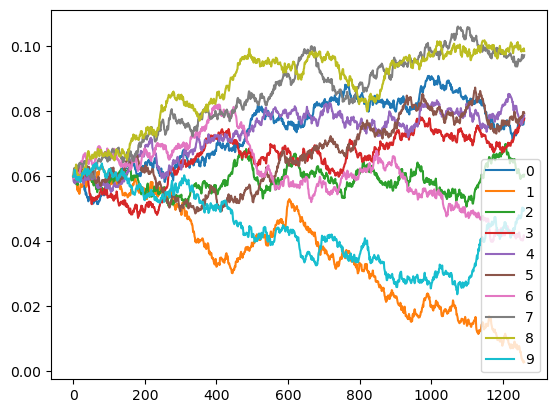

In [56]:
n_timesteps = 5*252
T_simul = 5
n_simul = 10
hw_process = ql.HullWhiteProcess(curve_disc, 0.05, 0.01)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(n_timesteps, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, T_simul, n_timesteps, rng, False)

simuls =  pd.DataFrame([np.array(seq.next().value()) for i in range(n_simul)]).T
simuls.plot();